#MATH80629A Project: Predicting BIXI bike usage based on historical weather data

A project by: 
* William Désilets
* Simon Drolet (11178019)
* Gabriella Bincoletto-Montpetit (11149602)

# Part 1: Data pre-processing

## 1.1. Import relevant packages

In [1]:
# Run this line into anaconda prompt to install XGBOOST: conda install -c anaconda py-xgboost
import xgboost

In [1]:
# Run this line into anaconda prompt: pip install holidays
import holidays as holidays

In [2]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
#from google.colab import files
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
#from geopy import distance
#from geopy.distance import great_circle
#from shapely.geometry import MultiPoint
#from geopy.distance import vincenty
import matplotlib.cm as cm
#import dask.dataframe as dd

## 1.2. Weather Data

### 1.2.1. Import weather files

In [2]:
# Since I have 84 files (7 years, 12 months per year) over 3 stations, I'll loop!

# This code lists the 252 weather URLs from our GitHub rep. Actually we only keep 162 because we remove Dec/Jan/Feb (No Bixis)!
weather_urls = list()
for s in [['7024745_','McTavish'],['7027329_','St-Hubert'],['7025251_','YUL']]: # McTavish, St-Hubert, YUL
    for y in range(7):
        for m in range(9):
            year = str(y + 2014)
            month = '0' + str(m+3) + '-'
            if len(month) == 4 : month = month[1:]
            url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/' + s[1] + '/fr_climat_horaires_QC_' + s[0] + month + year + '_P1H.csv'
            weather_urls.append(url)



I would like to die once please.
This is one extra test
Bonjour!


In [3]:
# Let's make all these CSVs into proper Pandas
weather_dfs = list()
n = 0
for file in weather_urls:
    weather_dfs.append(pd.read_csv(file))
  
    # A lot of columns are always empty, so let's remove them before anything else!
    weather_dfs[n] = weather_dfs[n].drop(['Date/Heure (HNL)','Temp Indicateur','Point de rosée Indicateur',\
                     'Hum. rel. Indicateur','Hauteur de précip. Indicateur',\
                     'Dir. du vent Indicateur','Vit. du vent Indicateur',\
                     'Visibilité Indicateur', 'Pression à la station Indicateur',\
                     'Hmdx Indicateur','Refroid. éolien Indicateur'],axis=1)
  
    # Let's clean up the "Heure" field so it's easier to use.
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].str.strip('0')
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].str.strip(':')
    weather_dfs[n]['Heure (HNL)'].mask(weather_dfs[n]['Heure (HNL)'] == '', '0', inplace=True)
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].astype(int)

    # BIXIs are only available from March 15 to November 15. Let's remove the useless days (keeping the day before)
    weather_dfs[n].drop(weather_dfs[n][(weather_dfs[n]['Mois'] == 3) & (weather_dfs[n]['Jour'] < 14)].index, inplace=True) # Mars
    weather_dfs[n].drop(weather_dfs[n][(weather_dfs[n]['Mois'] == 11) & (weather_dfs[n]['Jour'] > 15)].index, inplace=True) # Novembre

    # And we convert the field "Temps" to a list and remove NAN
    weather_dfs[n]['Temps'] = weather_dfs[n]['Temps'].fillna('ND')
    weather_dfs[n]['Temps'] = weather_dfs[n]['Temps'].str.split(',')

    n = n + 1
    if n % 21 == 0 : print('Upload %d percent complete' % (n/189*100)) # If I change the number of years this line won't work!

Upload 11 percent complete
Upload 22 percent complete
Upload 33 percent complete
Upload 44 percent complete
Upload 55 percent complete
Upload 66 percent complete
Upload 77 percent complete
Upload 88 percent complete
Upload 100 percent complete


### 1.2.2. Cleaning

In [4]:
# We find all the possible weather conditions that can be identified in "Temps" to create indicative variables
# From: https://climat.meteo.gc.ca/glossary_f.html 

  # Here is the list that will be used

"""
  ND (0s everywhere)
  nan (0s everywhere)
  *
  BROUILLARD: Brume sèche OU Fumée (1), Brouillard OU Chasse-poussière élevée (2), brouillard verglaçant (3)
  PLUIE: Pluie OU Averses de pluie (1), Pluie modérée OU Averses de pluie modérée (2), Pluie forte OU Averses de pluie forte (3), Pluie verglaçante OU Averses de pluie verglaçante (4)
  BRUINE: Bruine (1), bruine verglaçante (2)
  ORAGES: Orages (1)
  NEIGE: Neige OU Averses de neige OU Neige en grains (1), Neige modérée (2), Poudrerie élevée OU Averses de granules de glace ou de grésil OU Granules de glace ou grésil OU Grêle (3) 
  SOLEIL: Généralement dégagé (1), dégagé (2)
  NUAGES: Généralement nuageux (1), nuageux (2)
"""

# NUAGES
def fnuages(row):
    if ('Généralement nuageux' in row['Temps']):
        val = 1
    elif ('Nuageux' in row['Temps']):
        val = 2
    else:
        val = 0
    return val

# SOLEIL
def fsoleil(row):
    if ('Généralement dégagé' in row['Temps']):
        val = 2
    elif ('Dégagé' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# ORAGES
def forages(row):
    if ('Orages' in row['Temps']) or ('Orage' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# NEIGE
def fneige(row):
    if ('Poudrerie élevée' in row['Temps']) or ('Grêle' in row['Temps']) or ('Granules de glace ou grésil' in row['Temps']) or ('Averses de granules de glace ou de grésil' in row['Temps']):
        val = 3
    elif ('Neige modérée' in row['Temps']):
        val = 2
    elif ('Neige' in row['Temps']) or ('Averses de neige' in row['Temps']) or ('Neige en grains' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# PLUIE
def fpluie(row):
    if ('Pluie verglaçante' in row['Temps']) or ('Averses de pluie verglaçante' in row['Temps']):
        val = 4
    elif ('Pluie forte' in row['Temps']) or ('Averses de pluie forte' in row['Temps']):
        val = 3
    elif ('Pluie modérée' in row['Temps']) or ('Averses de pluie modérées' in row['Temps']):
        val = 2
    elif ('Pluie' in row['Temps']) or ('Averses de pluie' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# BROUILLARD
def fbrouillard(row):
  if ('Brouillard verglaçant' in row['Temps']):
    val = 3
  elif ('Brouillard' in row['Temps']) or ('Chasse-poussière élevée' in row['Temps']):
    val = 2
  elif ('Brume sèche' in row['Temps']) or ('Fumée' in row['Temps']):
    val = 1
  else:
    val = 0
  return val

# BRUINE
def fbruine(row):
    if ('Bruine verglaçante' in row['Temps']):
        val = 2
    elif ('Bruine' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# Applying all the functions
for df in weather_dfs:
    df['Pluie'] = df.apply(fpluie,axis=1)
    df['Neige'] = df.apply(fneige,axis=1)
    df['Orages'] = df.apply(forages,axis=1)
    df['Bruine'] = df.apply(fbruine,axis=1)
    df['Brouillard'] = df.apply(fbrouillard,axis=1)
    df['Nuages'] = df.apply(fnuages,axis=1)
    df['Soleil'] = df.apply(fsoleil,axis=1)




In [5]:
# We will merge all the dataframes together into one huge table to make the splitting/aggregating easier
weather_df = pd.DataFrame()
for df in weather_dfs:
    weather_df = pd.concat([weather_df, df], ignore_index=True)

In [6]:
# Some of the column which should contain floats or int contain strings. Let's fix!
# NOTE: Only run this cell once! Else it will fail.

# First we change commas to periods in numbers
weather_df['Longitude (x)'] = (weather_df['Longitude (x)'].str.replace(',','.')).astype(float)
weather_df['Latitude (y)'] = (weather_df['Latitude (y)'].str.replace(',','.')).astype(float)
weather_df['Temp (°C)'] = (weather_df['Temp (°C)'].str.replace(',','.')).astype(float)
weather_df['Point de rosée (°C)'] = (weather_df['Point de rosée (°C)'].str.replace(',','.')).astype(float)
weather_df['Hauteur de précip. (mm)'] = (weather_df['Hauteur de précip. (mm)'].str.replace(',','.')).astype(float)
weather_df['Visibilité (km)'] = (weather_df['Visibilité (km)'].str.replace(',','.')).astype(float)
weather_df['Pression à la station (kPa)'] = (weather_df['Pression à la station (kPa)'].str.replace(',','.')).astype(float)

# I'll also change the station IDs so it's easier to use later
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7024745, 1, inplace=True)
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7027329, 2, inplace=True)
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7025251, 3, inplace=True)
weather_df['stationID'] = weather_df['ID climatologique']

# Finally, we can drop the fields which we have transformed earlier
weather_df = weather_df.drop(['Temps','ID climatologique', 'Nom de la Station'], axis=1)

### 1.2.3. Relevant functions

In [7]:
# Here are some functions that will be useful later (for weighted averages)

# Distance (HAVERSINE)
def distance(lon1,lat1,lon2,lat2):
    R = 6367.5
    dlon = np.abs(np.radians(lon2) - np.radians(lon1)) 
    dlat = np.abs(np.radians(lat2) - np.radians(lat1)) 
    a = np.sin(dlat/ 2)**2 + np.cos(np.radians(lat2)) * np.cos(np.radians(lat1)) * np.sin(dlon / 2)**2
    L = R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return L

# Weigthed Average
def weighted(x, cols, w="Distance"):
    return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)

In [8]:
# Let's write a function that allows to create a new df according to the specifications that we want!
# First we can choose what data to keep (Which year, month, day)
# Second we choose how to aggregate the data!

def create_weather_df(years=[weather_df.Année.min(),weather_df.Année.max()]\
                      , months=[weather_df.Mois.min(),weather_df.Mois.max()]\
                      , days=[weather_df.Jour.min(),weather_df.Jour.max()]\
                      , hours=[weather_df['Heure (HNL)'].min(),weather_df['Heure (HNL)'].max()]\
                      , aggType = 1 # 1 = hourly ; 2 = daily ; 3 = monthly
                      , geo = list()): # We can insert [Lon, Lat] 
  
  # Filtre temporel
    rdf = weather_df[(weather_df['Année'] >= years[0]) & (weather_df['Année'] <= years[1])]
    rdf = rdf[(rdf['Mois'] >= months[0]) & (rdf['Mois'] <= months[1])]
    rdf = rdf[(rdf['Jour'] >= days[0]) & (rdf['Jour'] <= days[1])]
    rdf = rdf[(rdf['Heure (HNL)'] >= hours[0]) & (rdf['Heure (HNL)'] <= hours[1])]

  # Creating a date ID (will vary based on type of aggregation)
    rdf.Année = rdf.Année.astype(str)
    rdf.Mois = rdf.Mois.astype(str)
    rdf.Jour = rdf.Jour.astype(str)
    rdf['Heure (HNL)'] = rdf['Heure (HNL)'].astype(str)
    rdf.loc[rdf['Mois'].str.len() == 1, 'Mois'] = '0' + rdf['Mois']
    rdf.loc[rdf['Jour'].str.len() == 1, 'Jour'] = '0' + rdf['Jour']
    rdf.loc[rdf['Heure (HNL)'].str.len() == 1, 'Heure (HNL)'] = '0' + rdf['Heure (HNL)']
    rdf['dateIDh'] = (rdf.Année + rdf.Mois + rdf.Jour + rdf['Heure (HNL)']).astype(int)
    rdf['dateIDd'] = (rdf.Année + rdf.Mois + rdf.Jour).astype(int)
    rdf['dateIDm'] = (rdf.Année + rdf.Mois).astype(int)

  
    if not geo: # Average across all three stations
    # Aggregate hourly data by default
        rdf = rdf.groupby('dateIDh').agg(Temp=("Temp (°C)", "mean"),
                                      DewPoint=("Point de rosée (°C)", "mean"),
                                      HumRel=("Hum. rel (%)", "mean"),
                                      PrecipitationHgt=("Hauteur de précip. (mm)", "mean"),
                                      WindDir=("Dir. du vent (10s deg)", "mean"),
                                      WindSpd=("Vit. du vent (km/h)", "mean"),
                                      Vis=("Visibilité (km)", "mean"),
                                      Pkpa=("Pression à la station (kPa)", "mean"),
                                      Hmdx=("Hmdx", "mean"),
                                      WindChill=("Refroid. éolien", "mean"),
                                      Rain=("Pluie", "max"),
                                      Snow=("Neige", "max"),
                                      Thunderstorm=("Orages", "max"),
                                      Drizzle=("Bruine", "max"),
                                      Fog=("Brouillard", "max"),
                                      Cloudy=("Nuages", "max"),
                                      Sunny=("Soleil", "max"),
                                      dateIDd=("dateIDd","mean"),
                                      dateIDm=("dateIDm","mean"),
                                      )
    

    else: # When geo option is ACTIVE
        # Ajouter une colonne de distance
        rdf['Distance'] = rdf.apply(lambda x: distance(x['Longitude (x)'], x['Latitude (y)'], geo[0], geo[1]), axis=1)
        # Date IDs
        rdf_date = rdf.groupby('dateIDh').agg(dateIDd=("dateIDd","mean"), dateIDm=("dateIDm","mean"))  
        # Hourly aggregation, weighted by distance (for continuous variables) # NOTE !!!! PRECIPITATION HEIGHT AND VIS NOT WORKING I THINK
        rdf_grouped = rdf.groupby('dateIDh')
        rdf_weighted = rdf_grouped.apply(weighted,["Temp (°C)",
                                       "Point de rosée (°C)",
                                       "Hum. rel (%)",
                                       "Dir. du vent (10s deg)",
                                       "Vit. du vent (km/h)",
                                       "Pression à la station (kPa)",
                                       "Hmdx",
                                       "Refroid. éolien"])
        # We have to do it separately for the precipitation height and visibility because station 3 has all NAN fro Precipitation, and station 1 has all NAN for Visibility
        # NOTE: This is not the most elegant as it's somehow hardcoded. It means the function will fail if we get new weather stations.
        # Precipitation
        rdf_precip = rdf.loc[rdf['stationID'].isin([1,2])]
        rdf_grouped2 = rdf_precip.groupby('dateIDh')
        rdf_weighted2 = rdf_grouped2.apply(weighted,["Hauteur de précip. (mm)"])
        rdf_weighted2.rename(columns={'Hauteur de précip. (mm)':'PrecipitationHgt'}, inplace=True)
        # Visibility
        rdf_vis = rdf.loc[rdf['stationID'].isin([2,3])]
        rdf_grouped3 = rdf_vis.groupby('dateIDh')
        rdf_weighted3 = rdf_grouped3.apply(weighted,["Visibilité (km)"])
        rdf_weighted3.rename(columns={'Visibilité (km)':'Vis'}, inplace=True)
        # We rename the columns of the original big batch weighted averages
        rdf_weighted.rename(columns={'Temp (°C)':'Temp',
                                 'Point de rosée (°C)':'DewPoint',
                                 'Hum. rel (%)':'HumRel',
                                 'Dir. du vent (10s deg)':'WindDir',
                                 'Vit. du vent (km/h)':'WindSpd',
                                 'Pression à la station (kPa)':'Pkpa',
                                 'Refroid. éolien':'WindChill'}, inplace=True)
    
        # For the categorical variables, we take the value closest to the location
        rdf_min = rdf.loc[rdf['stationID'].isin([2,3])] # Pas de données texte pour la station 1!
        rdf_min = rdf_min.loc[rdf['Distance'] == rdf_min['Distance'].min()]
        rdf_min = rdf_min.set_index('dateIDh')
        rdf_min = rdf_min[['Pluie','Neige','Orages','Brouillard']]
        # Annnnnd rename again:
        rdf_min = rdf_min.rename(columns={'Pluie':'Rain',
                                     'Neige':'Snow',
                                     'Orages':'Thunderstorm',
                                     'Brouillard':'Fog'
                                      })
    
        # Finally we add the column about cloud cover and drizzle, which are only available at one station
        rdf_sun = rdf.groupby('dateIDh').agg(Drizzle=("Bruine","max"), Cloudy=("Nuages","max"), Sunny=("Soleil","max")) 

        # We concatenate all the pandas together. The resulting df has the same format has the 'non-geo' one so we can pass it to agg=2 or agg=3 easily
        rdf = pd.concat([rdf_date,rdf_weighted,rdf_weighted2,rdf_weighted3,rdf_min,rdf_sun], axis=1)
    
      
    if aggType == 2 or aggType == 3:
        # Compute daily data
        rdf.loc[rdf["PrecipitationHgt"] > 0, 'RainToday'] = 1
        rdf.loc[rdf["PrecipitationHgt"] == 0, 'RainToday'] = 0
        rdf = rdf.groupby('dateIDd').agg(avgTemp=("Temp", "mean"),
                                      maxTemp=("Temp", "max"),
                                      minTemp=("Temp", "min"),
                                      avgDewPoint=("DewPoint", "mean"),
                                      avgHumRel=("HumRel", "mean"),
                                      maxHumRel=("HumRel", "max"),
                                      minHumRel=("HumRel", "min"),
                                      sumPrecipitationHgt=("PrecipitationHgt", "sum"),
                                      timePrecipitation=("RainToday", "mean"),
                                      precipitationToday=("RainToday", "max"),
                                      avgWindDir=("WindDir", "mean"),
                                      avgWindSpd=("WindSpd", "mean"),
                                      maxWindSpd=("WindSpd", "max"),
                                      avgVis=("Vis", "mean"),
                                      avgPkpa=("Pkpa", "mean"),
                                      avgHmdx=("Hmdx", "mean"),
                                      avgWindChill=("WindChill", "mean"),
                                      maxWindChill=("WindChill", "max"),
                                      minWindChill=("WindChill", "min"),
                                      Rain=("Rain", "max"), # Qualifie l'intensité maximale des précipitations dans la journée
                                      Snow=("Snow", "max"),
                                      Thunderstorm=("Thunderstorm", "max"),
                                      Drizzle=("Drizzle", "mean"),
                                      Fog=("Fog", "mean"),
                                      percentCloudy=("Cloudy", "mean"),
                                      percentSunny=("Sunny", "mean"),
                                      dateIDm=("dateIDm","mean")
                                      )
      
        if aggType == 3:
        # Dans un mois les max-min ne sont plus très utiles!
            rdf = rdf.groupby('dateIDm').agg(avgTemp=("avgTemp", "mean"),
                                         avgHigh=("maxTemp", "mean"),
                                         avgLow=("minTemp", "mean"),
                                         avgHumRel=("avgHumRel", "mean"),
                                         sumPrecipitationHgt=("sumPrecipitationHgt", "sum"),
                                         avgDailyPrecipitation=("timePrecipitation", "mean"),
                                         daysRain=("precipitationToday", "sum"), 
                                         avgWindSpd=("avgWindSpd", "mean"),
                                         avgWindChill=("avgWindChill", "mean"),
                                         avgHighWindchill=("maxWindChill","mean"),
                                         avgLowWindchill=("minWindChill","mean"),
                                         percentCloudy=("percentCloudy", "mean"),
                                         percentSunny=("percentSunny", "mean")
                                         )

    return rdf

### 1.2.4. Create useful weather pandas

In [13]:
# You can then call the dataframe that you want with the "create_weater_df"
#  ****** But, adventurer, watch out: it takes much more time to generate the dataframe you want when you call the function with the GEO option. Choose wisely.
df = create_weather_df(years=[2018,2020], months=[7,11], days=[8,22], aggType=3) 
df.head()

,avgTemp,avgHigh,avgLow,avgHumRel,sumPrecipitationHgt,avgDailyPrecipitation,daysRain,avgWindSpd,avgWindChill,avgHighWindchill,avgLowWindchill,percentCloudy,percentSunny
dateIDm,,,,,,,,,,,,,
201807,23.655741,28.673333,17.995556,54.248148,25.80,0.041667,4.0,11.308333,NaN,NaN,NaN,0.166667,0.280556
201808,22.345648,26.575556,17.922222,69.792593,18.50,0.086111,9.0,9.856481,NaN,NaN,NaN,0.233333,0.233333
201809,17.477222,22.111111,12.864444,73.441667,57.20,0.069444,6.0,10.213889,NaN,NaN,NaN,0.188889,0.250000
201810,8.167130,11.497778,4.402222,69.633796,46.65,0.100000,9.0,15.274537,-3.888889,-2.666667,-5.000000,0.308333,0.130556
201811,-1.118229,1.291667,-4.279167,68.427083,27.00,0.130208,3.0,14.513889,-7.762584,-5.595238,-10.571429,0.260417,0.156250


In [10]:
# Weather data is compiled hourly (without location)
weather_hourly = create_weather_df(aggType=1)
weather_hourly.to_csv('weather_hourly.csv') 

In [11]:
# Weather data is compiled daily (without location)
weather_daily = create_weather_df(aggType=2)
weather_daily.to_csv('weather_daily.csv') 

In [12]:
# Weather data is compiled monthly (without location)
weather_monthly = create_weather_df(aggType=3)
weather_monthly.to_csv('weather_monthly.csv') 

## 1.2. BIXI Data

 ### 1.2.1. Importing BIXI trip data

In [3]:
# The data has been pre-processed offline, and then separated into 40 dataframes (10 per year from 2017 to 2020). 
#The exact steps are available,annexed at the end of the collab.

bixi_rides_urls = list()
for y in [2017, 2018, 2019, 2020]:  
    for m in range(1,10):
        year = str(y)
        dfnumber = str(m)
        url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/Final%20Bixi%20Data/bixi_' + year + '_' + dfnumber + '.csv'
        bixi_rides_urls.append(url)



In [4]:
# We can now turn the raw data located at these URLs into DFs **LONG RUNTIME ALERT**

bixi_rides_dfs = list()
for file in bixi_rides_urls:
    bixi_rides_dfs.append(pd.read_csv(file))
    
# Then we can concatenate the 40 dataframes into one central dataset.

bixi_master_data = pd.concat(bixi_rides_dfs)


In [17]:
bixi_master_data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,Start_Station_Key_ID,End_Station_Key_ID,start_longitude,start_latitude,end_longitude,end_latitude
0,2017-04-15 00:00,7060,2017-04-15 00:31,7060,1841,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
1,2017-04-17 15:33,7060,2017-04-17 15:36,7060,211,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
2,2017-04-21 18:55,7060,2017-04-21 19:26,7060,1851,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
3,2017-04-21 18:55,7060,2017-04-21 19:26,7060,1846,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
4,2017-05-12 15:46,7060,2017-05-12 17:16,7060,5396,0,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001


In [5]:
# Removing trips lasting less than one minute, as recommended by other studies in the field.

bixi_master_data = bixi_master_data.drop(bixi_master_data[bixi_master_data.duration_sec <= 60].index)
bixi_master_data

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,Start_Station_Key_ID,End_Station_Key_ID,start_longitude,start_latitude,end_longitude,end_latitude
0,2017-04-15 00:00,7060,2017-04-15 00:31,7060,1841,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
1,2017-04-17 15:33,7060,2017-04-17 15:36,7060,211,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
2,2017-04-21 18:55,7060,2017-04-21 19:26,7060,1851,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
3,2017-04-21 18:55,7060,2017-04-21 19:26,7060,1846,1,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
4,2017-05-12 15:46,7060,2017-05-12 17:16,7060,5396,0,20177060,20177060,-73.571569,45.463001,-73.571569,45.463001
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2020-09-29 18:02:15,6410,2020-09-29 18:10:35,7148,499,1,20206410,20207148,-73.638428,45.546408,-73.633568,45.559884
49996,2020-09-30 18:03:10,6410,2020-09-30 18:10:40,7148,450,1,20206410,20207148,-73.638428,45.546408,-73.633568,45.559884
49997,2020-10-01 14:43:03,6410,2020-10-01 14:49:43,7148,399,1,20206410,20207148,-73.638428,45.546408,-73.633568,45.559884
49998,2020-10-01 22:06:49,6410,2020-10-01 22:14:29,7148,460,1,20206410,20207148,-73.638428,45.546408,-73.633568,45.559884


In [ ]:
bixi_master_data.to_csv('bixi_master_data.csv') 
files.download('bixi_master_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 1.2.2. Importing location of BIXI stations




In [ ]:
# We will use our previous loop to import the annual Bixi station locations from GitHub. 

bixi_stations_urls = list()
for y in [2017, 2018, 2019, 2020]:
  year = str(y)
  url_2 = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/bixidata/Stations_' + year + '.csv'
  bixi_stations_urls.append(url_2)

In [ ]:
# Using the URLs assembled in our list, we will then create proper pandas dataframes from the raw data.

bixi_stations_dfs = list()
for file in bixi_stations_urls:
    bixi_stations_dfs.append(pd.read_csv(file))

In [ ]:
# Quickly declare individually our reference documents.
#stations_2014 = bixi_stations_dfs[0]
##stations_2015 = bixi_stations_dfs[1]
#stations_2016 = bixi_stations_dfs[2]
stations_2017 = bixi_stations_dfs[3]
stations_2018 = bixi_stations_dfs[4]
stations_2019 = bixi_stations_dfs[5]
stations_2020 = bixi_stations_dfs[6]

# Correcting data irregularities
stations_2019['code'] = stations_2019['Code']
stations_2019 = stations_2019.drop(['Code'], axis=1)
stations_2017 = stations_2017.drop(['is_public'], axis=1)

# Then, we will create a new key variable, specifically designed to join Longitude/Latitude values to our trip data. 

#stations_2014['Station_Key_ID'] = '2014' + stations_2014['code'].map(str)
#stations_2015['Station_Key_ID'] = '2015' + stations_2015['code'].map(str)
#stations_2016['Station_Key_ID'] = '2016' + stations_2016['code'].map(str)
stations_2017['Station_Key_ID'] = '2017' + stations_2017['code'].map(str)
stations_2018['Station_Key_ID'] = '2018' + stations_2018['code'].map(str)
stations_2019['Station_Key_ID'] = '2019' + stations_2019['code'].map(str) 
stations_2020['Station_Key_ID'] = '2020' + stations_2020['code'].map(str)

# Then, we can concatenate the dataframes into one final reference document.

bixi_master_stations = pd.concat([stations_2014, stations_2015, stations_2016, stations_2017, stations_2018, stations_2019,stations_2020])


### 1.2.3. Adding geographical location to the BIXI trip dataset

In [ ]:
# Due to limited RAM, we will have to split our main dataset to create new variables and effectuate operations. **RUNTIME ALERT - Limite côté RAM!!*

#master_2014 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2014']
#master_2015 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2015']
#master_2016 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2016']
#
#
#
#

In [ ]:
#master_2017 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2017']

In [ ]:
#master_2018 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2018']

In [ ]:
#master_2019 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2019']

In [ ]:
#master_2020 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2020']

In [ ]:
# Creating two sub-DFs to facilitate the merging process. 

start_long_lat = bixi_master_stations[['Station_Key_ID', 'longitude', 'latitude']]
start_long_lat.columns = ['Start_Station_Key_ID', 'start_longitude', 'start_latitude']

end_long_lat = bixi_master_stations[['Station_Key_ID', 'longitude', 'latitude']]
end_long_lat.columns = ['End_Station_Key_ID', 'end_longitude', 'end_latitude']

In [ ]:
# We will now create a loop to insert our merge key in the bike trips dataset, and then add the geographical values (Lon/Lat) based on this key.

for i in [master_2017, master_2018, master_2019, master_2020]:# master_2014, master_2015, master_2016, 
  i['Start_Station_Key_ID'] =  i['start_date'].astype(str).str[0:4] + i['start_station_code'].astype(str)
  i['End_Station_Key_ID'] =  i['end_date'].astype(str).str[0:4] + i['end_station_code'].astype(str)

 

In [ ]:
# Finally, adding the geographical values and then recreating our master_data set. **NOT SURPRISINGLY, LONG RUNTIME ALERT**

master_2017 = master_2017.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2017 = master_2017.merge(end_long_lat, on ='End_Station_Key_ID')

master_2018 = master_2018.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2018 = master_2018.merge(end_long_lat, on ='End_Station_Key_ID')

master_2019 = master_2019.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2019 = master_2019.merge(end_long_lat, on ='End_Station_Key_ID')

master_2020 = master_2020.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2020 = master_2020.merge(end_long_lat, on ='End_Station_Key_ID')

bixi_master_data = pd.concat([master_2017, master_2018, master_2019, master_2020])

In [ ]:
bixi_master_data.head 

<bound method NDFrame.head of                   start_date start_station_code  ... end_longitude end_latitude
0           2017-04-15 00:00               7060  ...    -73.571569    45.463001
1           2017-04-17 15:33               7060  ...    -73.571569    45.463001
2           2017-04-21 18:55               7060  ...    -73.571569    45.463001
3           2017-04-21 18:55               7060  ...    -73.571569    45.463001
4           2017-05-12 15:46               7060  ...    -73.571569    45.463001
...                      ...                ...  ...           ...          ...
3264736  2020-11-14 18:48:20               4001  ...    -73.691449    45.514734
3264737  2020-11-01 14:47:49               8068  ...    -73.691449    45.514734
3264738  2020-11-07 21:52:14               8022  ...    -73.691449    45.514734
3264739  2020-11-10 21:40:29               8022  ...    -73.691449    45.514734
3264740  2020-11-12 21:46:21               8022  ...    -73.691449    45.514734

[18855996

### 1.2.4. Aggregating function

In [6]:
# ******* WIP, please do not panic if this function fails *******

# This function will allow us to calculate the amount of bike rentals in ANY given time period
# It will also output calendar data (weekday, holiday) when appropriate
# Note: by any I mean hourly, daily or monthly
# Note#2: must also be part of the dataset - no information is available on pre-2017 dates

def calc_bike_volumes(df, years, months, days, hours, aggtype = 1): # Format [20XX,20XX], it's an interval! Same format for the other arguments please. No default values.
  
    pd.options.mode.chained_assignment = None  # default='warn'
    rdf = df

    # Creating a date ID (will vary based on type of aggregation)
    rdf['Année'] = rdf['start_date'].astype(str).str[0:4]
    rdf['Mois'] = rdf['start_date'].astype(str).str[5:7]
    rdf['Jour'] = rdf['start_date'].astype(str).str[8:10]
    rdf['Heure'] = rdf['start_date'].astype(str).str[11:13]
    rdf['dateIDh'] = (rdf.Année + rdf.Mois + rdf.Jour + rdf['Heure']).astype(int)
    rdf['dateIDd'] = (rdf.Année + rdf.Mois + rdf.Jour).astype(int)
    rdf['dateIDm'] = (rdf.Année + rdf.Mois).astype(int)
    
    # Creating columns to indicate weekdays and holidays
    rdf['start_date'] = pd.to_datetime(rdf['start_date']) 
    rdf['Semaine'] = rdf['start_date'].map(lambda x: x.weekday())
    rdf.loc[rdf['Semaine'] <= 4, 'Semaine'] = 1
    rdf.loc[rdf['Semaine'] > 4, 'Semaine'] = 0
    
    qc_holidays = []
    for date in holidays.Canada(years = [2014,2015,2016,2017,2018,2019,2020], prov='QC').items():
        qc_holidays.append(str(date[0]))
        
    rdf['Holidays'] = [1 if str(val).split()[0] in qc_holidays else 0 for val in rdf['start_date']]

    # Filtre temporel
    rdf = rdf[(rdf['Année'].astype(int) >= years[0]) & (df['Année'].astype(int) <= years[1])]
    rdf = rdf[(rdf['Mois'].astype(int) >= months[0]) & (rdf['Mois'].astype(int) <= months[1])]
    rdf = rdf[(rdf['Jour'].astype(int) >= days[0]) & (rdf['Jour'].astype(int) <= days[1])]
    rdf = rdf[(rdf['Heure'].astype(int) >= hours[0]) & (rdf['Heure'].astype(int) <= hours[1])]

    if (not years) or (not months) or (not days) or (not hours):
        print('Please input all the required arguments?')
  
    # This will aggregate what we need to get the number of trips in the given timeframe (by blocks) and average trip length.
    else:

    # Aggregate using the hour ID
        if aggtype == 1:
            rdf = rdf.groupby('dateIDh').agg(Weekday=("Semaine", "max"), Holiday=("Holidays", "max"),
                                             Duration=("duration_sec", "mean"),
                                             Volume=("duration_sec", "count"))
            return rdf

    # Aggregate using the day ID
        if aggtype == 2 :
            rdf = rdf.groupby('dateIDd').agg(Weekday=("Semaine", "max"), Holiday=("Holidays", "max"),
                                             Duration=("duration_sec", "mean"),
                                             Volume=("duration_sec", "count"))
            return rdf

    # Aggregate using the month ID
        if aggtype == 3:
            rdf = rdf.groupby('dateIDm').agg(Duration=("duration_sec", "mean"),
                                       Volume=("duration_sec", "count"))
            return rdf


In [8]:
# Testing the function (it works!)
rdf = calc_bike_volumes(bixi_master_data,[2017,2019],[3,11],[1,31],[0,23],aggtype=2)
rdf.head()

,Weekday,Holiday,Duration,Volume
dateIDd,,,,
20170501,1,0,430.454545,33
20170502,1,0,802.743902,82
20170503,1,0,648.926667,150
20170504,1,0,905.582353,170
20170505,1,0,741.436019,211


In [7]:
# Calculating the data I need

# Daily Data
data_daily = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=2)

In [8]:
data_daily.to_csv('data_daily.csv') 

In [9]:
# Hourly Data
data_hourly = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=1)

In [10]:
data_hourly.to_csv('data_hourly.csv') 

In [11]:
# Monthly Data
data_monthly = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=3)

In [12]:
data_monthly.to_csv('data_monthly.csv') 

## 1.3. Neighbourhood Clusters

### 1.3.1. Setting up the data

In [ ]:
# We will attemps to create neighbourhood clusters for BIXI stations using their latitude and longitude. 
# We will ignore the variable 'code' and will use the Station_Key_ID as the primary key.

bixi_master_stations.head()

,code,name,latitude,longitude,Station_Key_ID
0,6209,Milton / Clark,45.512520,-73.570620,20146209
1,6436,Côte St-Antoine / Clarke,45.486452,-73.595234,20146436
2,6214,Square St-Louis,45.517350,-73.569060,20146214
3,6248,St-Dominique / Rachel,45.518593,-73.581566,20146248
4,6164,Chambord / Laurier,45.532955,-73.584194,20146164


In [ ]:
# First, we see that there a lot of duplicates of the same stations.
bixi_master_stations.loc[bixi_master_stations['name']=='Square St-Louis']

# We are only interested in 2020 stations, so we will only keep Station_Key_ID starting with 2020. There are 640 stations.
bixi_master_stations = bixi_master_stations[bixi_master_stations['Station_Key_ID'].astype(str).str.startswith('2020')]
bixi_master_stations.tail()

,code,name,latitude,longitude,Station_Key_ID
636,8046,Mairie d'arrondissement Montréal-Nord (Hébert ...,45.593945,-73.638444,20208046
637,8071,Gare d'autocars de Montréal (Berri / Ontario),45.516926,-73.564257,20208071
638,8036,Messier / St-Joseph,45.539461,-73.576056,20208036
639,8069,Ateliers municipaux de St-Laurent (Cavendish /...,45.506176,-73.711186,20208069
640,8022,Centre des loisirs (Tassé / Grenet),45.514734,-73.691449,20208022


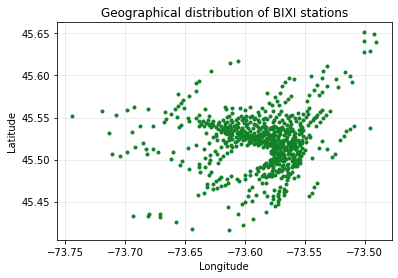

In [ ]:
# We then plot the geographical points; good news: it indeed looks like the BIXI station map! 
plot_bixi_master_stations = plt.plot(bixi_master_stations['longitude'], bixi_master_stations['latitude'],
             marker='.', linewidth=0, color='#128128')
plot_bixi_master_stations = plt.grid(which='major', color='#cccccc', alpha=0.45)
plot_bixi_master_stations = plt.title ('Geographical distribution of BIXI stations', family='DejaVu Sans', fontsize=12)
plot_bixi_master_stations = plt.xlabel('Longitude')
plot_bixi_master_stations = plt.ylabel('Latitude')
plot_bixi_master_stations = plt.show()

In [ ]:
# We then create a new dataframe to only keep the variables Station_Key_ID, Longitude and Latitude for our clustering analysis
cluster_bixi_stations=bixi_master_stations.loc[:,['Station_Key_ID','latitude','longitude']]
cluster_bixi_stations.head()

,Station_Key_ID,latitude,longitude
0,20206001,45.510163,-73.556637
1,20206002,45.539385,-73.541000
2,20206003,45.510824,-73.567172
3,20206004,45.509655,-73.554009
4,20206005,45.500208,-73.571138


### 1.3.2. K-Means method

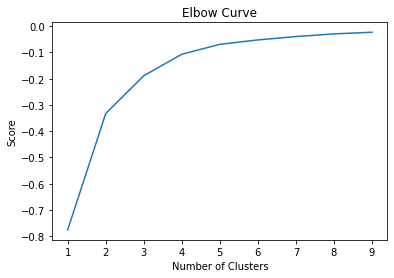

In [ ]:
# We will validate the number of clusters by using the elbow method 
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = cluster_bixi_stations[['latitude']]
X_axis = cluster_bixi_stations[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize the graph -- we see that 3 or 4 clusters could be interesting.
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
# Computer K-means clustering using 4 clusters

kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(cluster_bixi_stations[cluster_bixi_stations.columns[1:3]])
cluster_bixi_stations['cluster_label'] = kmeans.fit_predict(cluster_bixi_stations[cluster_bixi_stations.columns[1:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(cluster_bixi_stations[cluster_bixi_stations.columns[1:4]]) # Labels of each point
cluster_bixi_stations.tail(10)

,Station_Key_ID,latitude,longitude,cluster_label
631,20208020,45.484919,-73.637415,3
632,20208068,45.512994,-73.682498,2
633,20208053,45.541548,-73.565012,1
634,20208047,45.605533,-73.628024,2
635,20208048,45.614430,-73.612233,0
636,20208046,45.593945,-73.638444,2
637,20208071,45.516926,-73.564257,1
638,20208036,45.539461,-73.576056,1
639,20208069,45.506176,-73.711186,2
640,20208022,45.514734,-73.691449,2


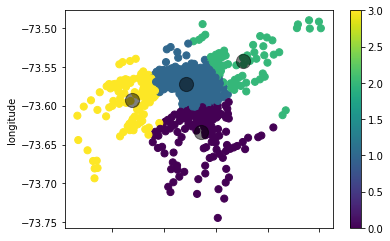

In [ ]:
# Visualize the clusters and centroids 

cluster_bixi_stations.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### 1.3.3. DBSCAN method

In [ ]:
# We now create a new dataframe to only keep the variables Station_Key_ID, Longitude and Latitude for our clustering analysis
cluster_bixi_stations2=bixi_master_stations.loc[:,['Station_Key_ID','latitude','longitude']]
cluster_bixi_stations2.head()

NameError: ignored

In [ ]:
# define the number of kilometers in one radiation
# which will be used to convert esp from km to radiation
kms_per_rad = 6371.0088

In [ ]:
# define a function to calculate the geographic coordinate 
# centroid of a cluster of geographic points
# it will be used later to calculate the centroids of DBSCAN cluster
# because Scikit-learn DBSCAN cluster class does not come with centroid attribute.
def get_centroid(cluster):
  """calculate the centroid of a cluster of geographic coordinate points
  Args:
    cluster coordinates, nx2 array-like (array, list of lists, etc) 
    n is the number of points(latitude, longitude)in the cluster.
  Return:
    geometry centroid of the cluster
    
  """
  cluster_ary = np.asarray(cluster)
  centroid = cluster_ary.mean(axis = 0)
  return centroid

# testing get_centroid function
test_cluster= [[ 43.70487299, -79.57753802], 
               [ 43.71138367, -79.56524418],
               [ 43.72616079, -79.57319998],
               [ 43.73547907, -79.56258364],
               [ 43.72070325, -79.57202018],
               [ 43.73126031, -79.5598719 ]]
test_centroid = get_centroid(test_cluster)
print(test_centroid)

[ 43.72164335 -79.56840965]


In [ ]:
# convert eps to radians for use by haversine
epsilon = 0.1/kms_per_rad

NameError: ignored

In [ ]:
# Extract intersection coordinates (latitude, longitude)
bixi_coords = cluster_bixi_stations2[['latitude', 'longitude']].values

In [ ]:
import time
from sklearn import metrics

start_time = time.time()
dbsc = (DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
        .fit(np.radians(bixi_coords)))
bixi_cluster_labels = dbsc.labels_

In [ ]:
# get the number of clusters
num_clusters = len(set(dbsc.labels_))
print(num_clusters)

23


In [ ]:
# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(cluster_bixi_stations2), num_clusters, 100*(1 - float(num_clusters) / len(cluster_bixi_stations2)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(bixi_coords, bixi_cluster_labels)))


Clustered 641 points down to 23 clusters, for 96.4% compression in 757.46 seconds
Silhouette coefficient: 0.007


In [ ]:
# turn the clusters into a pandas series, where each element is a cluster of points
dbsc_clusters = pd.Series([bixi_coords[bixi_cluster_labels==n] for n in range(num_clusters)])

In [ ]:
# get centroid of each cluster
bixi_centroids = dbsc_clusters.map(get_centroid)
# unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
cent_lats, cent_lons = zip(*bixi_centroids)
# from these lats/lons create a new df of one representative point for each cluster
centroids_pd = pd.DataFrame({'longitude':cent_lons, 'latitude':cent_lats})

print(centroids_pd)

    longitude   latitude
0  -73.586867  45.520806
1  -73.532806  45.608566
2  -73.543266  45.464159
3  -73.495469  45.640371
4  -73.514708  45.532378
5  -73.495067  45.537226
6  -73.644244  45.417151
7  -73.593099  45.429471
8  -73.497850  45.628777
9  -73.496164  45.650476
10 -73.679300  45.433614
11 -73.601194  45.422451
12 -73.605475  45.435676
13 -73.612916  45.416310
14 -73.657416  45.426123
15 -73.639531  45.592419
16 -73.744440  45.551886
17 -73.719597  45.558109
18 -73.690872  45.560731
19 -73.707490  45.552535
20 -73.609122  45.615965
21 -73.713552  45.531865
22 -73.628024  45.605533


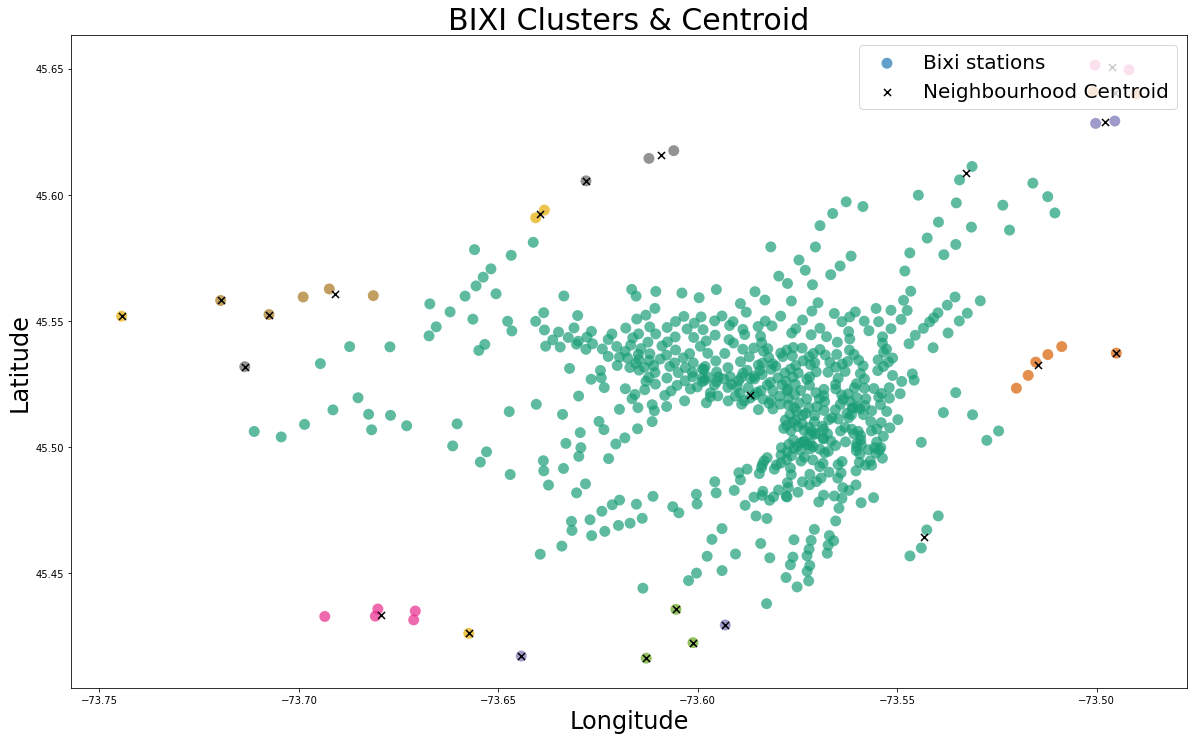

In [ ]:
# Plot the clusters and cluster centroid
fig, ax = plt.subplots(figsize=[20, 12])
bixi_scatter = ax.scatter(cluster_bixi_stations2['longitude'], cluster_bixi_stations2['latitude'], c=bixi_cluster_labels, cmap = cm.Dark2, edgecolor='None', alpha=0.7, s=120)
centroid_scatter = ax.scatter(centroids_pd['longitude'], centroids_pd['latitude'], marker='x', linewidths=2, c='k', s=50)
ax.set_title('BIXI Clusters & Centroid', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=24)
ax.set_ylabel('Latitude', fontsize = 24)
ax.legend([bixi_scatter, centroid_scatter], ['Bixi stations', 'Neighbourhood Centroid'], loc='upper right', fontsize = 20)

In [ ]:
# convert eps to radians for use by haversine
epsilon = 1.5/kms_per_rad

# Extract intersection coordinates (latitude, longitude)
bixi_coords = cluster_bixi_stations2.as_matrix(columns = ['latitude', 'longitude'])

start_time = time.time()
dbsc = (DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
        .fit(np.radians(bixi_coords)))
bixi_cluster_labels = dbsc.labels_

# get the number of clusters
num_clusters = len(set(dbsc.labels_))

# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(facility_pd), num_clusters, 100*(1 - float(num_clusters) / len(facility_pd)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(fac_coords, fac_cluster_labels)))

# turn the clusters into a pandas series,where each element is a cluster of points
dbsc_clusters = pd.Series([fac_coords[fac_cluster_labels==n] for n in range(num_clusters)])
Clustered 1,396 points down to 20 clusters, for 98.6% compression in 0.13 seconds
Silhouette coefficient: -0.166



In [ ]:
X = cluster_bixi_stations[['latitude', 'longitude']].values

In [ ]:
def greatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return vincenty((lat1, lon1), (lat2, lon2)).meters

NameError: ignored

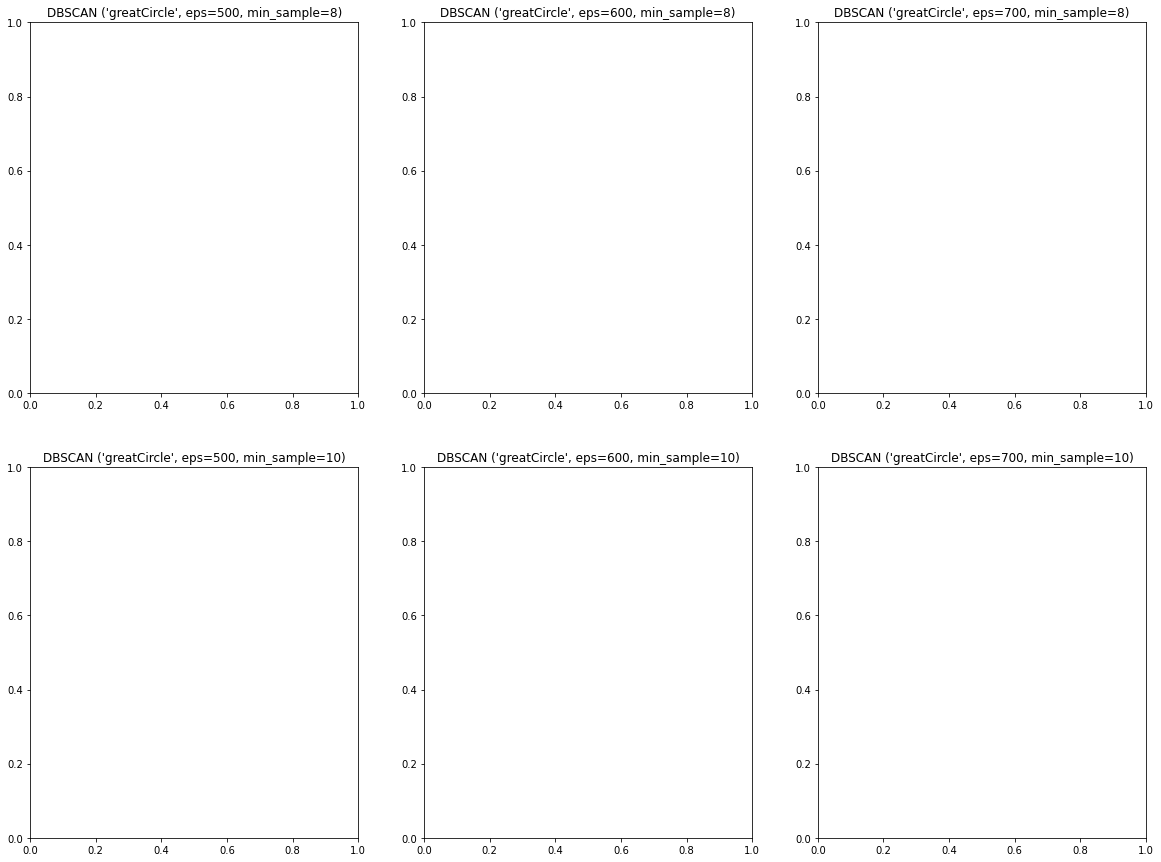

In [ ]:
eps = [500, 600, 700]    # unit: meter
min_sample = [8, 10]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
  for i in range(n1):
    est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(X)
    cluster_bixi_stations['cluster'] = est.labels_.tolist()

    ax = plt.subplot(n2, n1, n1*j+i+1)
    ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))

plot_stations_map(ax, cluster_bixi_stations)


In [ ]:
# Merge cluster labels in bixi_master_stations dataframe
clustering_bixi_stations = clustering_bixi_stations[['code','cluster_label']]
clustering_bixi_stations.head(5)

bixi_master_stations = bixi_master_stations.merge(clustering_bixi_stations, left_on='code', right_on='code')
bixi_master_stations.head(50)

,code,name,latitude,longitude,Station_Key_ID,cluster_label
0,6209,Milton / Clark,45.512520,-73.570620,20146209,2
1,6209,Milton / Clark,45.512520,-73.570620,20146209,2
2,6209,Milton / Clark,45.512520,-73.570620,20146209,2
3,6209,Milton / Clark,45.512520,-73.570620,20146209,2
4,6209,Milton / Clark,45.512520,-73.570620,20146209,2
5,6209,Milton / Clark,45.512520,-73.570620,20146209,2
6,6209,Milton / Clark,45.512520,-73.570620,20146209,2
7,6209,Milton / Clark,45.512520,-73.570620,20156209,2
8,6209,Milton / Clark,45.512520,-73.570620,20156209,2
9,6209,Milton / Clark,45.512520,-73.570620,20156209,2


# PART 2: Modeling

In [3]:
# Let's fetch the CSVs
# BIXI data
url_data_hourly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_hourly.csv'
data_hourly = pd.read_csv(url_data_hourly)
url_data_daily = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_daily.csv'
data_daily = pd.read_csv(url_data_daily)
url_data_monthly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_monthly.csv'
data_monthly = pd.read_csv(url_data_monthly)

# Weather data
url_weather_hourly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_hourly.csv'
weather_hourly = pd.read_csv(url_weather_hourly)
url_weather_daily = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_daily.csv'
weather_daily = pd.read_csv(url_weather_daily)
url_weather_monthly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_monthly.csv'
weather_monthly = pd.read_csv(url_weather_monthly)

# I'll merge bixi data with weather data so that proper food to feed to xgboost
hourly = pd.concat([weather_hourly, data_hourly], axis=1, join="inner")
hourly.to_csv('global_hourly.csv')
daily = pd.concat([weather_daily, data_daily], axis=1, join="inner")
daily.to_csv('global_daily.csv')
monthly = pd.concat([weather_monthly, data_monthly], axis=1, join="inner")
monthly.to_csv('global_monthly.csv')

# ANNEX: Testing the meteostat.net API

In [ ]:
pip install meteostat

  Created wheel for meteostat: filename=meteostat-1.1.1-cp37-none-any.whl size=15529 sha256=a09fd2f7e7fb4d8a6934659060c7d303946a7365ae9eb68989586be276d62eeb
  Stored in directory: /root/.cache/pip/wheels/93/96/13/4f94dd63c2625b172dc8773ea53fb9e58bf46d0f1b5abd21bf
Successfully built meteostat


In [ ]:
# import all relevant meteostat packages
from datetime import datetime
from meteostat import Stations
from meteostat import Daily
from meteostat import Point

In [ ]:
# check stations available in the montreal area
stations = Stations()
stations = stations.nearby(49.2497, -73.5673)
station = stations.fetch(1)

print(station)

# Remarque: la plupart des stations sont assez éloignées de Montréal.

                 name country region  ... daily_start  daily_end      distance
id                                    ...                                     
71523  Chamouchouane       CA     QC  ...  1995-11-09 2021-03-15  16203.748455

[1 rows x 14 columns]


In [ ]:
# Test pour voir si les données météo concordent avec ce qu'on trouve sur Météomédia malgré tout. Testons juin 2020.
start = datetime(2020, 6, 1)
end = datetime(2020, 6, 30)

data = Daily(station, start=start, end=end)
data = data.normalize()
data = data.fetch()

print(data)
# Conclusion: Il manque beaucoup de données, et celles qu'on a ne sont pas fiables! Nous allons devoir télécharger les données d'Environnement Canada!

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
time                                                                  
2020-06-01   5.8  -0.2  11.8   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-03   8.3  -0.2  16.8   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-05  12.4   6.7  18.1   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-06  10.7   2.6  18.7   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-07   9.8   1.8  17.7   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-08   9.0  -0.4  18.4   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-09  11.1   1.8  20.4   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-10   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-11  18.6  11.8  25.3   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-06-12   9.1   5.2  12.9   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2020-0

In [ ]:
# Je tente d'utiliser le module d'interpolation pour voir si ça donne de meilleurs résultats!
datamtl = Point(49.2497, -73.5673)

start = datetime(2021, 1, 1)
end = datetime(2021, 1, 1)

data = Daily(datamtl, start=start, end=end)
data = data.normalize()
data = data.fetch()

print(data)

# Météomedia donne -0.2 et -5.1, donc meteostat est vraiment dans le champ.

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
time                                                                  
2021-01-01 -14.7 -23.8  -5.5   NaN   NaN   NaN   NaN   NaN   NaN   NaN


**CONCLUSION:**
Meteostat fonctionne très bien, mais malheureusement les résultats sont très douteux. Je recommande que nous utilisions les données brutes des stations météo d'environnement Canada.

On retrouve les donnnées au: https://climat.meteo.gc.ca/historical_data/search_historic_data_f.html ; il est facile de télécharger les données CSV pour la période qui nous intéresse!